In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import urllib
import csv
import glob
import argparse
import numpy as np
import pandas as pd
from pandas import concat
from pandas import DataFrame
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn import datasets, linear_model
import scipy.io as sio
import datetime
import requests
from dateutil.relativedelta import relativedelta
import contextily as ctx
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timezone
from mintpy.utils import readfile, writefile
from mintpy.defaults.plot import *
from mintpy.objects.gps import search_gps, GPS
from mintpy.objects import sensor
from mintpy.utils import utils as ut
from mintpy.view import prep_slice, plot_slice
from mintpy.cli import view, timeseries2velocity

from utils.helper_functions import prepend_scratchdir_if_needed
from utils.helper_functions import find_nearest_start_end_date
from utils.helper_functions import get_dem_extent
from utils.plot_functions import get_basemap
from utils.plot_functions import plot_shaded_relief
from utils.plot_functions import modify_colormap
from utils.plot_functions import add_colorbar
from utils.seismicity import get_earthquakes
from utils.seismicity import normalize_earthquake_times
from utils.gps import get_GPS
from utils.insar import get_eos_file
from utils.insar import generate_view_velocity_cmd
from utils.insar import generate_view_ifgram_cmd

%load_ext jupyter_ai

In [2]:
EXAMPLE = """example:
  plot_data.py  MaunaLoaSenDT87 MaunaLoaSenAT124 
  plot_data.py  MaunaLoaSenDT87       
"""

def create_parser(subparsers=None):
    synopsis = 'Plotting of InSAR, GPS and Seismicity data'
    epilog = EXAMPLE
    parser = argparse.ArgumentParser(description='Plot InSAR, GPS and seismicity data\n')

    line_file = os.path.dirname(os.path.abspath("__file__")) + '/data/hawaii_lines_new.mat'

    parser.add_argument('data_dir', nargs='*', help='Directory(s) with InSAR data.\n')

    parser.add_argument('--plotBox', '--subset-lalo', dest='plot_box', default='19.29:19.6,-155.79:-155.41',
                        help='geographic area plotted')
    parser.add_argument('--startDate', dest='start_date', default='20220801',help='start date')
    parser.add_argument('--endDate', dest='end_date', default='20221115',help='end date')
    parser.add_argument('--seismicity', dest='flag_seismicity', action='store_true', default=True,
                        help='flag to add seismicity')
    parser.add_argument('--noseismicity', dest='flag_noseismicity', action='store_true',default=False,
                        help='flag to remove seismicity')
    parser.add_argument('--gps', dest='flag_gps', action='store_true', default=True,
                        help='flag to add gps vectors')
    parser.add_argument('--nogps', dest='flag_nogps', action='store_true',default=False,
                        help='flag to remove gps vectors')
    parser.add_argument('--plotType', dest='plot_type', default='velocity',
                        help='Type of plot: velocity, ifgram, shaded_relief (Default: velocity).')
    parser.add_argument('--lines', dest='line_file', default=line_file, help='fault file')
    parser.add_argument('--gpsScaleFac', dest='gps_scale_fac', default=500, help='GPS scale factor')
    parser.add_argument('--gpsKeyLength', dest='gps_key_length', default=4, help='GPS key length')
    parser.add_argument('--gpsUnits', dest='gps_unit', default="cm", help='GPS units')
 
    args = parser.parse_args()
    
    if len(args.data_dir) < 1 or len(args.data_dir) > 2:
        parser.error('ERROR: You must provide 1 or 2 directory paths.')
    if len(args.data_dir) == 2:
        args.plot_type='horzvert'
    if args.flag_noseismicity:
       args.flag_seismicity = False
    del args.flag_noseismicity
    if args.flag_nogps:
       args.flag_gps = False
    del args.flag_nogps
    
    inps = args
    inps.plot_box = [float(val) for val in inps.plot_box.replace(':', ',').split(',')]  # converts to plot_box=[19.3, 19.6, -155.8, -155.4]

    #inps.argv = iargs if iargs else sys.argv[1:]

    return inps

def is_jupyter():
    jn = True
    try:
        get_ipython()
    except:
        jn = Fals
    return jn

def main(iargs=None):
    print('iargs:', iargs)
    inps = create_parser(iargs)

    print('inps:',inps)
    return inps

###########################################################################################

if __name__ == '__main__':

    if is_jupyter():
        cmd = 'plot_data.py --help'
        cmd = 'plot_data.py MaunaLoaSenDT87 --plotType ifgram --noseismicity --nogps'
        cmd = 'plot_data.py MaunaLoaSenAT124 MaunaLoaSenDT87'
        cmd = 'plot_data.py MaunaLoaSenDT87 --plotType shaded_relief --noseismicity --nogps'
        cmd = 'plot_data.py MaunaLoaSenDT87 --plotType shaded_relief'
        cmd = cmd.rstrip()
        sys.argv = cmd.split(' ')

    inps=main(sys.argv[1:])
    

iargs: ['MaunaLoaSenDT87', '--plotType', 'shaded_relief']
inps: Namespace(data_dir=['MaunaLoaSenDT87'], plot_box=[19.29, 19.6, -155.79, -155.41], start_date='20220801', end_date='20221115', flag_seismicity=True, flag_gps=True, plot_type='shaded_relief', line_file='/Users/famelung/Downloads/test_notebook/data/hawaii_lines_new.mat', gps_scale_fac=500, gps_key_length=4, gps_unit='cm')


Text(0.5, 1.0, '20220801 - 20221115')

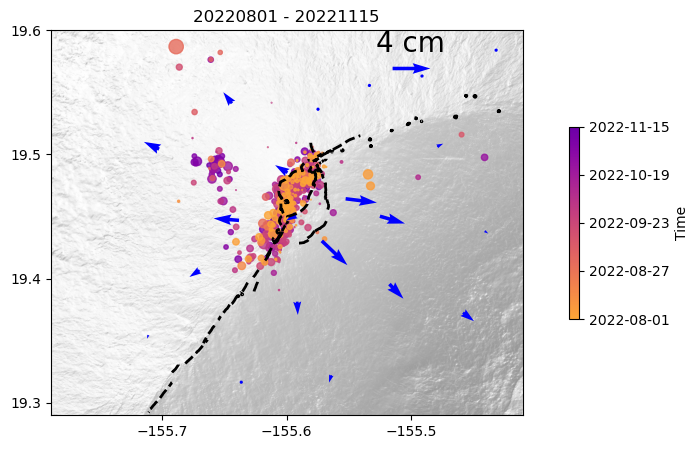

In [5]:
%%capture --no-display

data_dir = inps.data_dir[0]
plot_box = inps.plot_box
start_date = inps.start_date
end_date = inps.end_date
plot_type = inps.plot_type
line_file = inps.line_file
flag_seismicity = inps.flag_seismicity
flag_gps = inps.flag_gps
gps_scale_fac = inps.gps_scale_fac
gps_key_length = inps.gps_key_length
gps_unit = inps.gps_unit

# Hardwired: move to argparse
depth_range="0 10"
cmap_name = "plasma_r"; exclude_beginning = 0.2; exclude_end = 0.2

# Hardwired for Hawaii
date12 = '20221216_20230202'  # to plot an example descending ifgram
GPS_dir = os.getenv('SCRATCHDIR') + '/MaunaLoa/MLtry/data/'
dem_file = GPS_dir + 'demGeo.h5'  
GPS_list_file = GPS_dir + 'GPS_BenBrooks_03-05full.txt'

# get dem, earthquake and GPS data, normalize event times for plotting)
dem_shade, dem_extent = get_basemap(dem_file)
events_df = get_earthquakes(start_date, end_date, plot_box)
norm_times = normalize_earthquake_times(events_df, start_date, end_date)
cmap = modify_colormap( cmap_name = cmap_name, exclude_beginning = exclude_beginning, exclude_end = exclude_end, show = False)

gps,lon,lat,U,V,Z,quiver_label = get_GPS(GPS_dir, GPS_list_file, plot_box, start_date, end_date, gps_unit, gps_key_length)

work_dir = prepend_scratchdir_if_needed(data_dir)
if plot_type == 'velocity':
    eos_file, out_dir, vel_file = get_eos_file(work_dir)
    start_date_mod, end_date_mod = find_nearest_start_end_date(eos_file, start_date, end_date)
    start_date = start_date_mod
    end_date = end_date_mod
    cmd = f'{eos_file} --start-date {start_date} --end-date {end_date} --output {vel_file}'
    timeseries2velocity.main( cmd.split() )
    
# Cell to plot GPS on shaded relief or interferogram
# %load_ext autoreload
# %autoreload 2
  
fig, ax = plt.subplots(figsize=[12, 5] )
    
if plot_type == 'shaded_relief':
    plot_shaded_relief(ax, dem_file, plot_box = plot_box)
else:
    if plot_type == 'velocity':
        cmd = generate_view_velocity_cmd(vel_file, plot_box)
    elif plot_type == 'ifgram':
        cmd = generate_view_ifgram_cmd(work_dir, date12, plot_box)
    data, atr, tmp_inps = prep_slice(cmd)
    ax, tmp_inps, im, cbar = plot_slice(ax, data, atr, tmp_inps)

# plot events
if flag_seismicity:
    ax.scatter(events_df["Longitude"],events_df["Latitude"],s=2*events_df["Magnitude"] ** 3,
    c=norm_times,cmap=cmap,alpha=0.8)
    add_colorbar(ax = ax, cmap = cmap, start_date = start_date, end_date = end_date)
if flag_gps:
    quiv=ax.quiver(lon, lat, U, V, scale = gps_scale_fac, color='blue')
    ax.quiverkey(quiv, -155.50, 19.57, gps_key_length*10 , quiver_label, labelpos='N',coordinates='data',
                      color='blue',fontproperties={'size': 20}) 
    
# plot fault lines
lines=sio.loadmat(line_file,squeeze_me=True);
ax.plot(lines['Lllh'][:,0],lines['Lllh'][:,1],color='black', linestyle='dashed',linewidth=2)

ax.set_title(start_date + ' - ' + end_date);


In [4]:
# # print(eos_file)
# atr = readfile.read_attribute(eos_file)
# mask, dict_mask = readfile.read(eos_file, datasetName="/HDFEOS/GRIDS/timeseries/quality/mask")
# # temporal_coherence, dict_temp_coh = readfile.read(eos_file, datasetName="/HDFEOS/GRIDS/timeseries/quality/temporalCoherence")

# atr['FILE_TYPE'] = 'mask'
# mask_file = vel_file.replace('velocity','maskTempCoh')
# writefile.write(mask, out_file=mask_file, metadata=atr)

# fig, ax = plt.subplots(figsize=[12, 5])
# cmd = generate_view_velocity_cmd(vel_file, mask_file, plot_box)
# #cmd = generate_view_velocity2_cmd(vel_file, mask_file, plot_box)

# print(cmd)
# data, atr, inps = prep_slice(cmd)
# ax, inps, im, cbar = plot_slice(ax, data, atr, inps)